# Inference - Patch 

Contains: 
- Inference on Single Patches (not merged)

### Import Packages

In [2]:
import torch 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import sys
sys.path.insert(0, '..')
from fastai.utils.collect_env import show_install
from evaluation.metrics_tumor import * 
from slide.process_slides import *
from slide.pytorch_helper import *
from slide.pytorch_augmentations import *
from slide.new_pytorch_buildings_dataset import *
import os, cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from fastai.vision import *
from sklearn.metrics import confusion_matrix
import time
import torchmetrics
import torchvision

### Define dataset type

In [3]:
#define dataset type
# dataset_type = "scc_tumor_segmentation"
# dataset_type = "mammaCA_tumor_segmentation"
# dataset_type = "tubule_formation_segmentation"
dataset_type = "pleomorphism_segmentation"

### Set Parameters

In [4]:
if dataset_type == "tubule_formation_segmentation" or dataset_type == "pleomorphism_segmentation": 
    image_folder = "../Data/crops_rescaled"
    annotations_file = "../Data/CMC_Tumor_Tub_Pleo.json"
    csv_path =  "../Data/datasets.csv"
    level = 1
    down_factor = 4 
    num_patches= 1 
    patch_size =  512 
    width = patch_size
    height= patch_size
    batch_size =  1  
    epochs = 10 
    log_interval = 55
    load_pretrained = True
    white_mask_application = True
    only_train_head = True
    only_train_last_layer = True
    tumor_id = None
    if dataset_type == "tubule_formation_segmentation": 
        pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_tubule_formation_segmentation_model_level_1.pth"
        label_dict = {'Other':0,'Tubular': 1} 
        reduced_label_dict = {'Other':0,'Tubular': 1}
        label_dis = [0,1]
        num_classes = 2
    if dataset_type == "pleomorphism_segmentation": 
        pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_pleomorphism_segmentation_model_level_1_15_03.pth"
        label_dict = {'Other':0, 'Bg':1,'Pleo1': 2, 'Pleo2': 3, 'Pleo3': 4} 
        reduced_label_dict = {'Other':0, 'Bg':1,'Pleo1': 2, 'Pleo2': 3, 'Pleo3': 4}
        num_classes = 5
        label_dis = [0,0,0.8,0.5, 0.7]


else: 
    pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_mammaCA_tumor_segmentation_model_level_1_12_03_23.pth"
    image_folder ="../Data/crops_rescaled"
    annotations_file = "../Data/CMC_Tumor_Tub_Pleo.json"
    csv_path =  "../Data/datasets.csv"
    label_dict = {'Other':0, 'Bg':1,'Tumor': 2, 'KeinTumor': 3}
    tumor_id = None 
    reduced_label_dict = {'Tumor': 2, 'KeinTumor': 3}
    label_dis = [0,1]
    num_classes = 4

### DB supercategories for different tasks

In [5]:
if dataset_type == "tubule_formation_segmentation":
    poly_klasse = "tub_id"
    name = 'supercategory_TubFormation'
    id = 'id_super_tub'
    tumor_id = None 


if dataset_type == "pleomorphism_segmentation":
    poly_klasse = "pleo_id"
    name = 'supercategory_Pleo'
    id = 'id_super_pleo'
    tumor_id = None 

if dataset_type == "scc_tumor_segmentation": 
    poly_klasse = "tumor_id"
    name = 'supercategory_1'
    id = 'id_super'
    tumor_id = tumor_id 

if dataset_type == "mammaCA_tumor_segmentation": 
    poly_klasse = "tumor_id"
    name = 'supercategory_1'
    id = 'id_super'
    tumor_id = tumor_id 

In [6]:
level = 1
down_factor = 2 
num_patches= 1 
patch_size = 512 
width = patch_size
height= patch_size
batch_size =  1
n_classes = 4 

In [7]:
# class_rgb values 
# Get RGB values of required classes
select_class_rgb_values =  [[v] for k,v in label_dict.items()]

print('Selected classes and their corresponding RGB values in labels:')
print('Class RGB values: ', select_class_rgb_values)
print("dataset type = ", dataset_type)

Selected classes and their corresponding RGB values in labels:
Class RGB values:  [[0], [1], [2], [3], [4]]
dataset type =  pleomorphism_segmentation


### Load Test as List

In [8]:
_, _, test_files= load_slides(["train","valid", "test"], target_folder = image_folder, csv_path = csv_path, annotations_file = annotations_file, label_dict = reduced_label_dict, dataset_type = dataset_type)
test_data = create_patches(test_files, patches_per_slide=num_patches)

100%|██████████| 300/300 [00:00<00:00, 1348650.80it/s]


In [9]:
test_data = test_data[:10]

### Preprocessing for Testing

In [10]:
from albumentations.pytorch import ToTensorV2
import albumentations as album
albumentations_transform_test = album.Compose([
    #preprocessing - using Fraukes mean und std 
    album.Normalize(
        mean=[0.7587, 0.5718, 0.6572],
        std=[0.0866, 0.1118, 0.0990],
    ),
])

### Loading best saved model

In [15]:
best_model = torch.load(pretrained_model, map_location="cuda")
best_model.eval()

### Test Dataloader

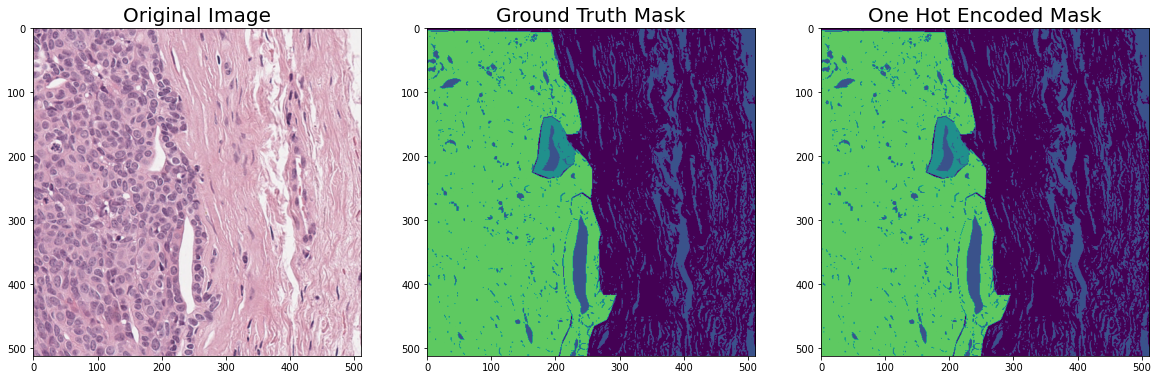

In [18]:
test_dataset = BuildingsDataset(
    image_paths = test_data, 
    annotations_file = annotations_file,
    num_patches = num_patches,
    class_rgb_values=select_class_rgb_values, 
    label_dict=label_dict,
    reduced_label_dict = reduced_label_dict,
    patch_size = patch_size,
    transform = None,
    staining = False,
    level = level,
    white_mask_application =True, 
    poly_klasse = poly_klasse,
    tumor_id = tumor_id,
    label_dis = label_dis,
    slide_resize = False)

test_dataloader = DataLoader(test_dataset)
image, mask = test_dataset[9]
maske = mask[3]
one_hot_encoded_mask = reverse_one_hot(mask)

visualize(
    areas = None,
    dict = label_dict,
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask),select_class_rgb_values), 
    one_hot_encoded_mask = reverse_one_hot(mask), 
)

[0.0, 1.0, 2.0, 3.0, 4.0]


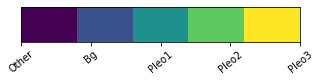

In [19]:
plt.figure(figsize=(num_classes,5))
bounds = list(range(0, len(label_dict)))
ax = plt.subplot()
fig = plt.imshow(np.array([[v for k,v in label_dict.items()]]), vmin=0, vmax=len(label_dict)-1, cmap='viridis',  extent=[0,len(label_dict)-1,0,0.5])
div = num_classes/ len(label_dict)
t = round(-1* div,2)
ticks = []
for i in range(0, len(label_dict)): 
    t = t+div
    ticks.append(t)
print(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels([k for k,v in label_dict.items()], rotation = 40) 
plt.yticks([])
plt.show()

### Final Visualization

In [21]:
test_dataset = BuildingsDataset(
    image_paths = test_data, 
    annotations_file = annotations_file,
    num_patches = num_patches,
    class_rgb_values=select_class_rgb_values, 
    label_dict=label_dict,
    reduced_label_dict = reduced_label_dict,
    patch_size = patch_size,
    transform = False,
    staining = False,
    level = level,
    white_mask_application =white_mask_application, 
    poly_klasse = poly_klasse,
    tumor_id = tumor_id,
    label_dis = label_dis,
    slide_resize = False)

test_dataloader = DataLoader(test_dataset)

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


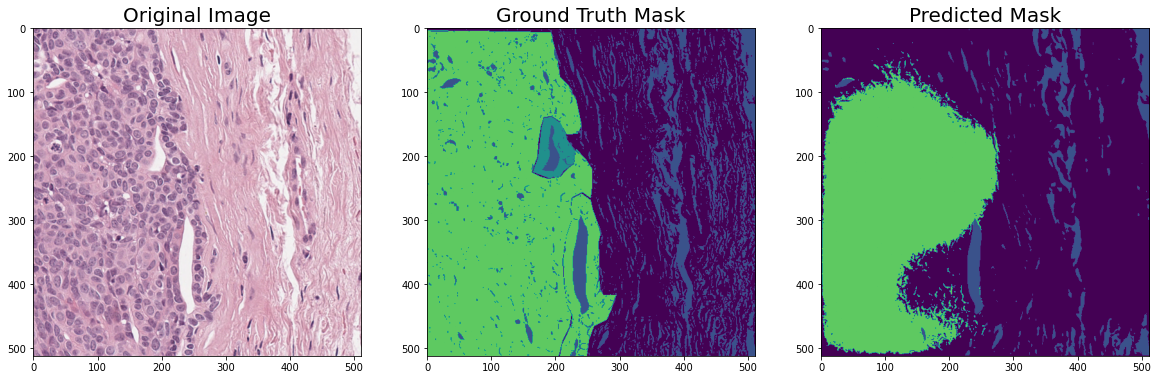

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


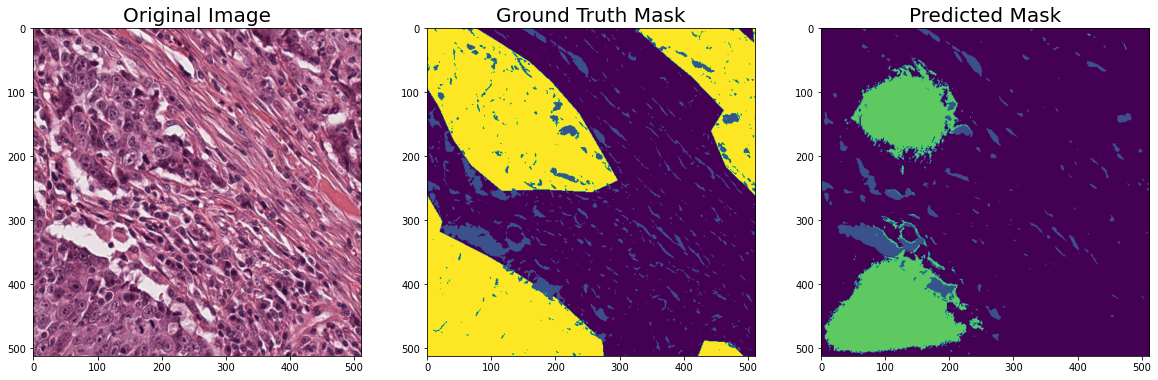

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


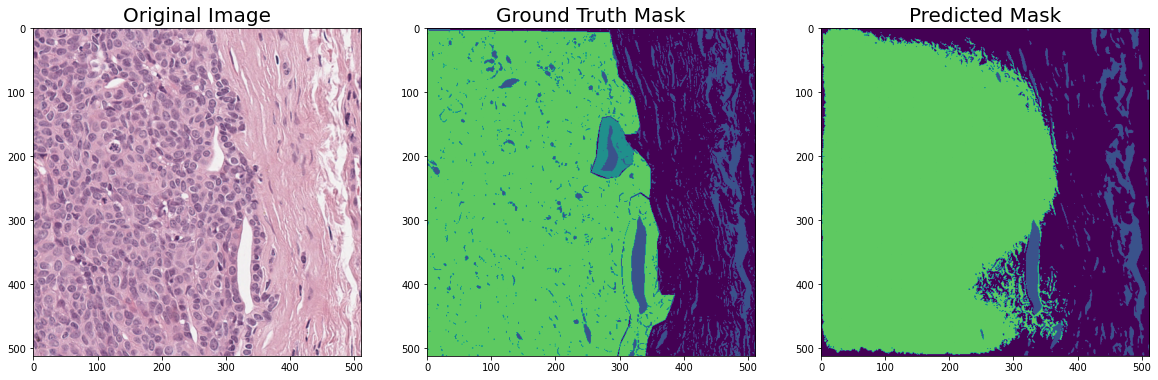

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


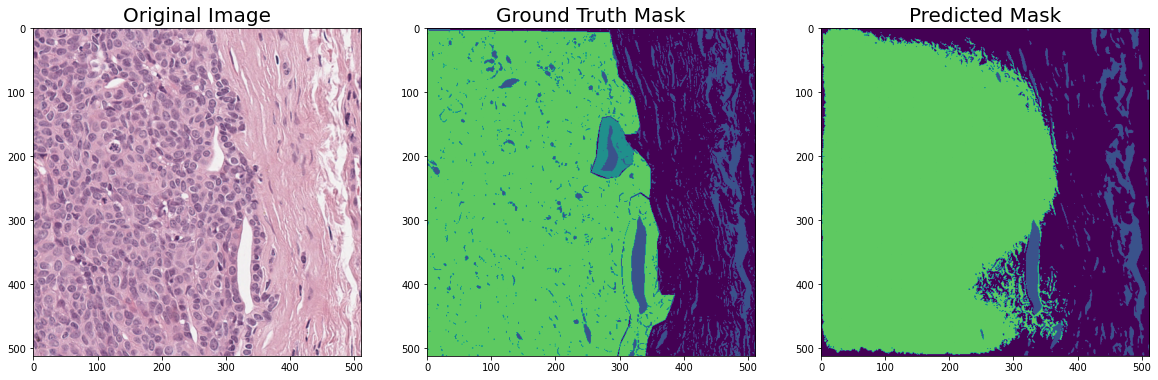

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


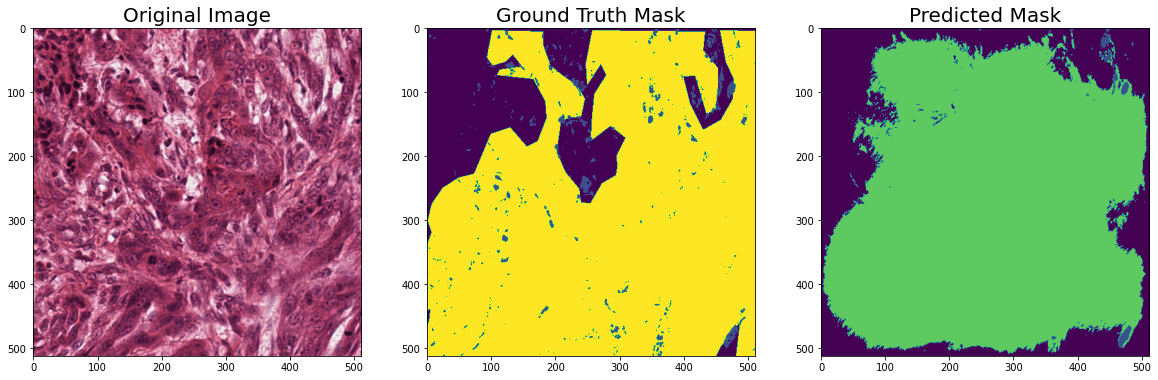

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


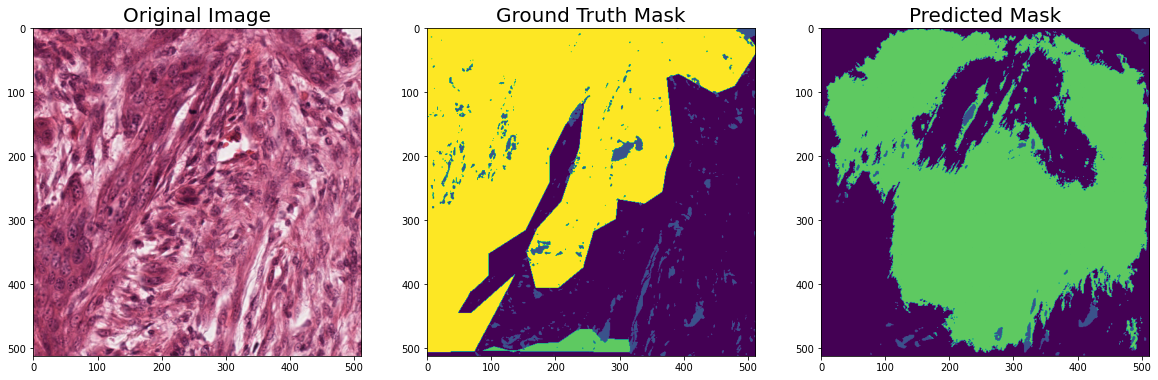

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


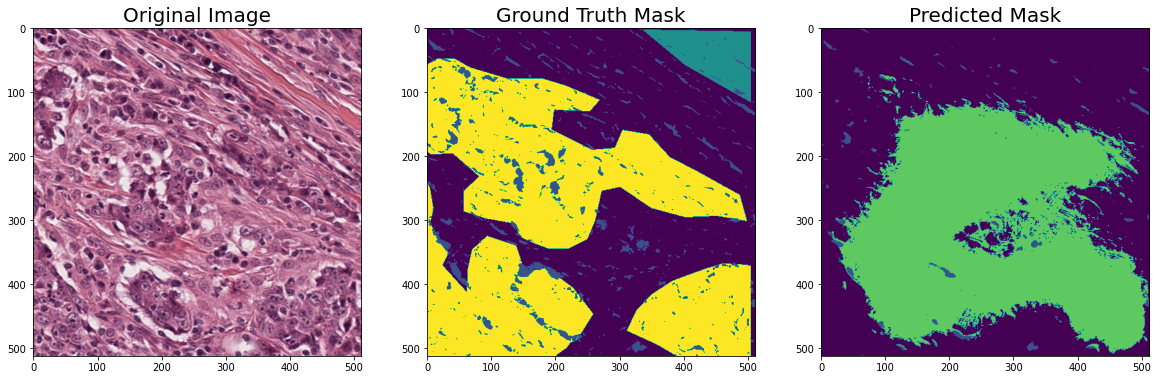

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


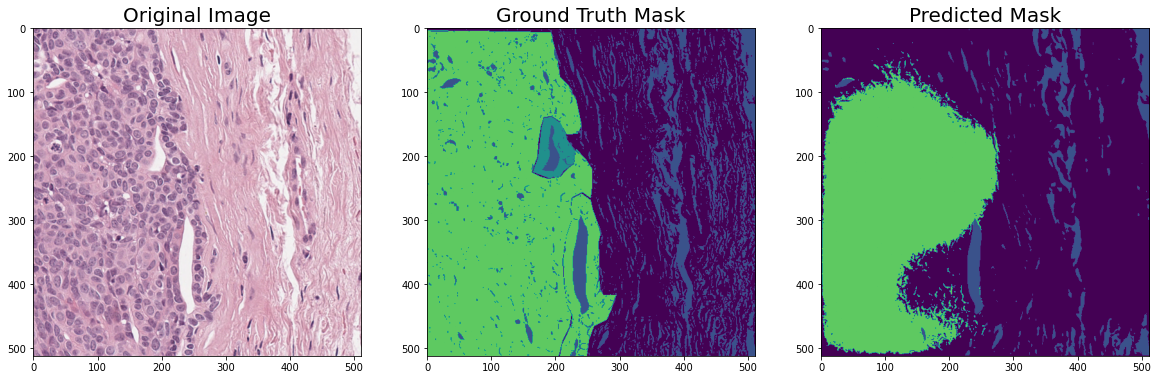

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


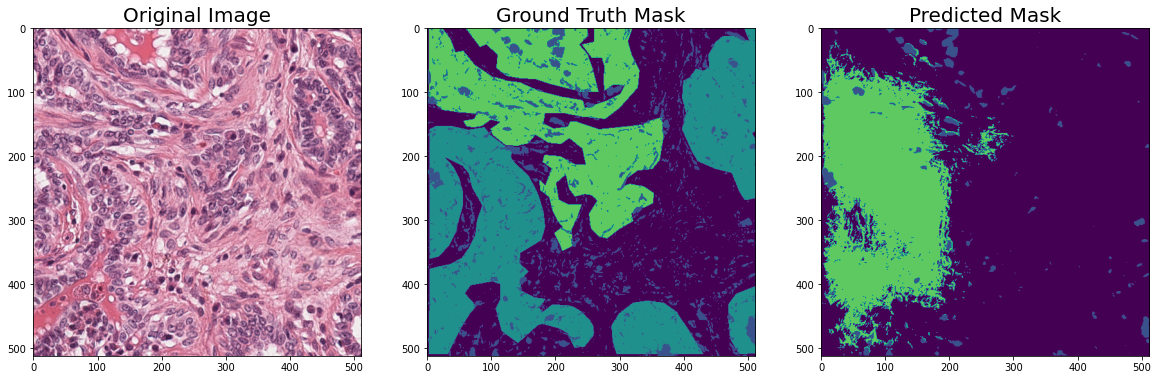

(5, 512, 512)
new shape (512, 512, 5)
reverse encoded shape (512, 512)


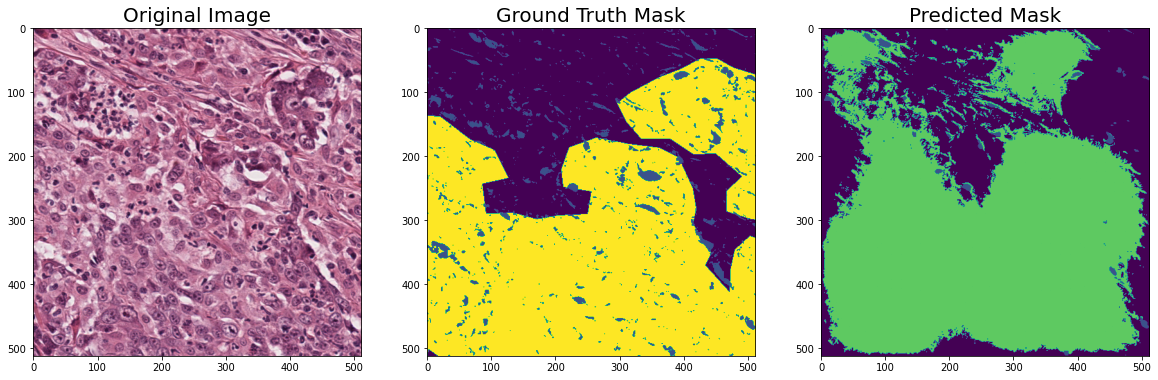

In [22]:
best_model.eval()
with torch.no_grad():
    for idx in range(len(test_dataset)):
        #get random image and corresponding mask
        image_gt, gt_mask = test_dataset[idx]
        #image to visualize
        image_vis = (image_gt.astype('uint8')).reshape(patch_size,patch_size,3)

        #normalize test image with transform_test
        image_dict = albumentations_transform_test(image = image_gt)
        image_test = image_dict['image']
        
        #test image toTensor
        image_test = image_test.transpose(2, 0, 1).astype('float32')
        #load on GPU
        x_tensor = torch.from_numpy(image_test).to("cuda")  #.unsqueeze(0)
        
        # Predict test image
        pred_mask = best_model(x_tensor.reshape(1,3,patch_size,patch_size)) #input of 4D required

        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        print(pred_mask.shape)
        pred_mask = np.transpose(pred_mask,(1,2,0))
        print("new shape", pred_mask.shape)
        #Transform a 2D array in one-hot format (depth is num_classes)
        one_hot_encoded_mask = reverse_one_hot(pred_mask)
        pred_mask = reverse_one_hot(pred_mask)
        print("reverse encoded shape", pred_mask.shape)
        gt_mask = reverse_one_hot(gt_mask)
            
        visualize(
            areas = None,
            dict=  label_dict,
            original_image = image_vis,
            ground_truth_mask = gt_mask,
            predicted_mask = pred_mask,
        )